# Compare Energies with Different Methods
We have a database computed with TTM, DFT and MP2. Let's see how they compare

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.metrics import r2_score
from ase.db import connect
from ase.io.xyz import simple_write_xyz
from ase import units
from io import StringIO
import pandas as pd
import numpy as np

## Load in the Data
Get the data from the different databases, combine them into a single dataframe

In [2]:
def load_database_to_pandas(path: str, name: str) -> pd.DataFrame:
    """Read an ASE database to a Pandas dataframe
    
    Args:
        path: Path to the ASE databases
    Returns:
        Dataframe with the filename as the key
    """
    with connect(path) as db:
        results = defaultdict(list)
        for row in db.select(""):
            if 'method' in row:
                method = f'{row["method"]}//{row["basis"]}'
            elif 'basis' in row:
                method = f'{name}//{row["basis"]}'
            else: 
                method = name
                
            
            xyz_fp = StringIO()
            simple_write_xyz(xyz_fp, [row.toatoms()])
                
            nodes = row.get('num_nodes', 1)
            results[method].append({'filename': row['filename'],
                                    'xyz': xyz_fp.getvalue(),
                                    'n_waters': int(row.natoms // 3),
                                    'source': row['filename'].split("_")[0],
                                    f'runtime_{method}': row['runtime'],
                                    f'nodes_{method}': nodes,
                                    f'cost_{method}': nodes * row['runtime'] / 3600,
                                    f'energy_{method}': row['energy'],
                                    f'energy_per_water_{method}': row['energy'] / int(row.natoms) * 3,
                                    f'force_{method}': row.forces})
    
    # Turn them into dataframes
    data = pd.concat([
        pd.DataFrame(v).set_index('filename') for v in results.values()
    ], axis=1)
    return data

Drop off the hydrodb avtz energies

In [3]:
data = [
    load_database_to_pandas(path, name)
    for path, name in [
        ('initial-ttm.db', 'ttm'),
        ('initial-psi4.db', 'dft'),
        ('initial.db', 'mp2')
    ]
]
data = pd.concat(data, axis=1)

Drop duplicate columns

In [4]:
data = data.loc[:,~data.columns.duplicated()].copy()

Normalize by the energy above the most-stable cluster

In [5]:
lowest_energy = data['energy_per_water_mp2//aug-cc-pvtz'].idxmin()
print(f'Using {lowest_energy} as a reference')

Using min_2249639.xyz as a reference


In [6]:
names = [c[17:] for c in data.columns if c.startswith('energy_per_water')]

In [7]:
data[[f'energy_{n}' for n in names]].count()

energy_ttm                     1720
energy_pbe0-d3//aug-cc-pvdz    1720
energy_pbe0//aug-cc-pvdz       1720
energy_mp2//aug-cc-pvdz        1720
energy_mp2//aug-cc-pvtz        1720
dtype: int64

In [8]:
for name in names:
    ref_energy = data[f'energy_per_water_{name}'][lowest_energy]
    data[f'energy_normed_{name}'] = data[f'energy_per_water_{name}'] - ref_energy
    data[f'energy_normed_{name}'] /= units.kcal / units.mol
    print(f'Reference energy for {name}: {ref_energy:.2f} eV/water')

Reference energy for ttm: -0.47 eV/water
Reference energy for pbe0-d3//aug-cc-pvdz: -2078.38 eV/water
Reference energy for pbe0//aug-cc-pvdz: -2078.32 eV/water
Reference energy for mp2//aug-cc-pvdz: -2075.64 eV/water
Reference energy for mp2//aug-cc-pvtz: -2077.49 eV/water


In [9]:
data[[c for c in data.columns if 'normed' in c]].sort_values('energy_normed_mp2//aug-cc-pvtz').head(15)

,energy_normed_ttm,energy_normed_pbe0-d3//aug-cc-pvdz,energy_normed_pbe0//aug-cc-pvdz,energy_normed_mp2//aug-cc-pvdz,energy_normed_mp2//aug-cc-pvtz
filename,,,,,
min_2249639.xyz,0.000000,0.000000,0.000000,0.000000,0.000000
min_1930862.xyz,0.033216,0.007914,0.046176,-0.011635,0.013832
min_1933997.xyz,0.055370,0.048292,0.020912,0.038755,0.027746
min_1932988.xyz,0.049799,0.078003,0.173344,0.045226,0.081214
min_1937085.xyz,0.069298,0.113795,0.133961,0.076746,0.084071
min_1943025.xyz,0.088667,0.089882,0.127765,0.062690,0.095645
min_1982257.xyz,0.167561,0.110433,0.088207,0.097172,0.099431
min_1948890.xyz,0.103730,0.110573,0.166213,0.086678,0.106414
hydrodb_ee56c8.xyz,0.174175,0.172068,0.130918,0.148893,0.127951


In [10]:
data.groupby('n_waters')[['runtime_mp2//aug-cc-pvtz', 'nodes_mp2//aug-cc-pvtz', 'cost_mp2//aug-cc-pvtz']].median()

,runtime_mp2//aug-cc-pvtz,nodes_mp2//aug-cc-pvtz,cost_mp2//aug-cc-pvtz
n_waters,,,
3,273.970866,16.0,1.217648
4,418.773193,16.0,1.861214
5,670.864447,16.0,2.981620
6,1599.392593,16.0,7.108412
7,2399.272860,16.0,10.663435
8,3153.368628,16.0,14.014972
9,4257.508402,16.0,18.922260
10,5763.887559,16.0,25.617278
11,8308.246604,16.0,36.925540


Generally, clusters below 15 were run on Cori KNL and larger on Perlmutter CPU.

## Plot
Show how different things are between TTM and DFT

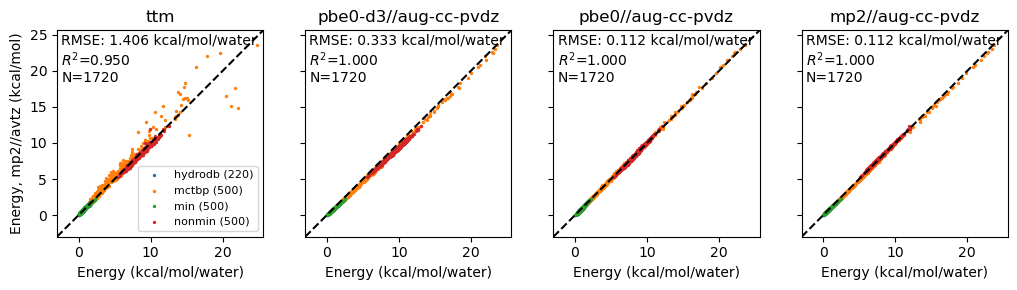

In [11]:
fig, axs = plt.subplots(1, len(names) - 1, figsize=(10.5, 3.), sharey=True)

not_avtz = [n for n in names if 'mp2//aug-cc-pvtz' not in n]
for name, ax in zip(not_avtz, axs):
    col = f'energy_normed_{name}'
    err = (data[col] - data['energy_normed_mp2//aug-cc-pvtz']).abs()
    count = err.count()
    mae = err.mean()
    rmse = np.sqrt((err ** 2).mean())
    r2 = np.corrcoef(data[col], data['energy_normed_mp2//aug-cc-pvtz'])[0, 1]
    ax.text(0.02, 0.75, f'RMSE: {rmse:.3f} kcal/mol/water\n$R^2$={r2:.3f}\nN={count}', transform=ax.transAxes)
    ax.set_xlabel(f'Energy (kcal/mol/water)')
    ax.set_title(name)
    
    for gid, group in data.groupby('source'):
        count = np.logical_not(group['energy_normed_mp2//aug-cc-pvtz'].isnull()).sum()
        ax.scatter(group[col], group['energy_normed_mp2//aug-cc-pvtz'], s=2, label=f'{gid} ({count})')
    ax.set_xlim([-3, data['energy_normed_mp2//aug-cc-pvtz'].max() + 2])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

# Make labels
axs[0].set_ylabel('Energy, mp2//avtz (kcal/mol)')
axs[0].legend(fontsize=8, loc='lower right')

fig.tight_layout()
fig.savefig('figures/comparison-to-mp2-avtz.png', dpi=320)

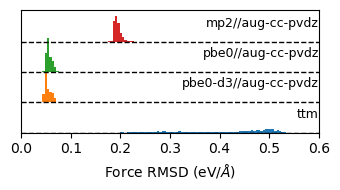

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

not_avtz = [n for n in names if 'mp2//aug-cc-pvtz' not in n]
bins = np.linspace(0, 0.6, 128)
offset = 75
ax.set_xlim(0, 0.6)
for i, name in enumerate(not_avtz):
    col = f'force_{name}'
    force_rmsd = [np.linalg.norm(np.subtract(x, y), axis=1).mean() for x, y in zip(data[col], data['force_mp2//aug-cc-pvtz'])]
    ax.hist(force_rmsd, bins=bins, bottom=i * offset, label=name, density=True)
    ax.plot(ax.get_xlim(), [offset * i] * 2, 'k--', lw=1)
    ax.text(0.6, (i + 0.5) * offset, name, ha='right', fontsize=9)

ax.set_yticks([])
ax.set_xlabel('Force RMSD (eV/$\\AA$)')
fig.tight_layout()
fig.savefig('figures/comparison-to-mp2-avtz-force.png', dpi=320)

Save the data for others

In [13]:
data.to_csv('comparison-water-clusters.csv')